In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set_theme()

In [2]:
train_data = pd.read_csv('train.csv',sep=',',index_col='id')
test_data = pd.read_csv('test.csv',sep=',',index_col='id')

In [3]:
train_data.shape, test_data.shape

((22730, 17), (15154, 16))

*train_data has an extra column for sale price*

In [4]:
train_data.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [5]:
test_data.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
id,,,,,,,,,,,,,,,,
22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8
22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4
22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2
22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5
22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9


## Data Exploration

In [6]:
train_data.isnull().sum().sort_values(ascending=False)

squareMeters         0
isNewBuilt           0
hasGuestRoom         0
hasStorageRoom       0
garage               0
attic                0
basement             0
hasStormProtector    0
made                 0
numberOfRooms        0
numPrevOwners        0
cityPartRange        0
cityCode             0
floors               0
hasPool              0
hasYard              0
price                0
dtype: int64

In [7]:
test_data.isnull().sum().sort_values(ascending=False)

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
dtype: int64

In [8]:
train_data.dtypes

squareMeters           int64
numberOfRooms          int64
hasYard                int64
hasPool                int64
floors                 int64
cityCode               int64
cityPartRange          int64
numPrevOwners          int64
made                   int64
isNewBuilt             int64
hasStormProtector      int64
basement               int64
attic                  int64
garage                 int64
hasStorageRoom         int64
hasGuestRoom           int64
price                float64
dtype: object

In [9]:
train_data.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,2.273000e+04,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,2.273000e+04
mean,4.658622e+04,48.241091,0.475891,0.452750,47.305983,50013.795996,5.585042,5.620766,2008.005059,0.467972,0.460009,5283.646634,5067.981698,530.469644,0.461681,5.153058,4.634457e+06
std,4.952124e+04,28.226428,0.499429,0.497773,47.777207,30006.637729,2.739533,2.713026,118.826777,0.498984,0.498409,3047.084412,3097.347939,274.840604,0.498540,3.055246,2.925163e+06
min,8.900000e+01,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04
25%,2.039275e+04,25.000000,0.000000,0.000000,25.000000,22936.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2977.250000,2599.000000,297.000000,0.000000,3.000000,2.041739e+06
50%,4.448400e+04,47.000000,0.000000,0.000000,45.000000,50414.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,4977.000000,515.000000,0.000000,5.000000,4.450823e+06
75%,7.154700e+04,75.000000,1.000000,1.000000,69.000000,76291.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7746.000000,7652.000000,767.000000,1.000000,8.000000,7.159920e+06
max,6.071330e+06,100.000000,1.000000,1.000000,6000.000000,491100.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000428e+07


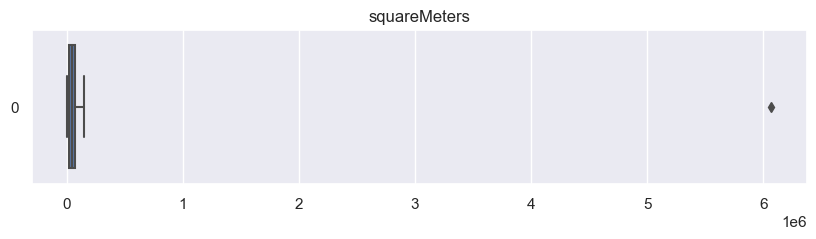

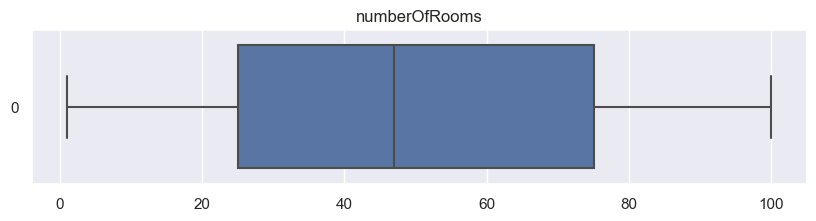

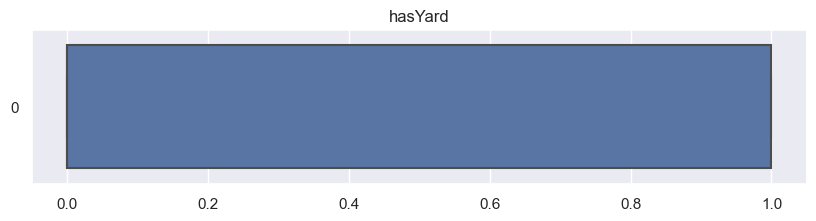

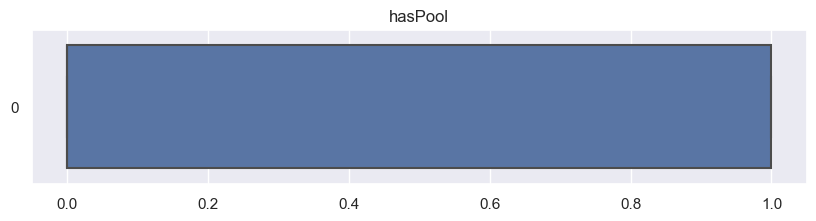

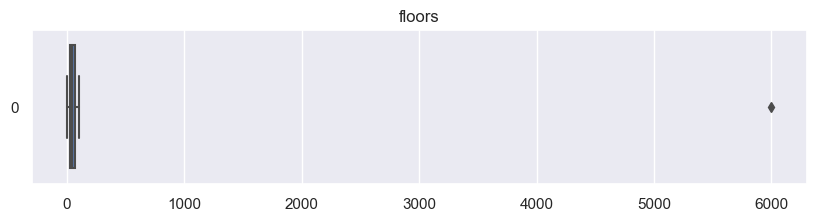

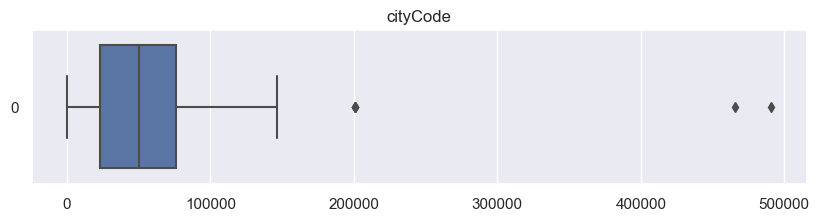

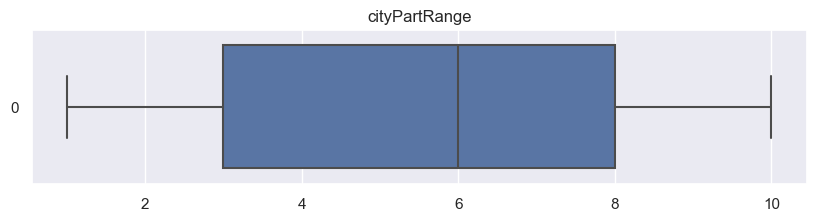

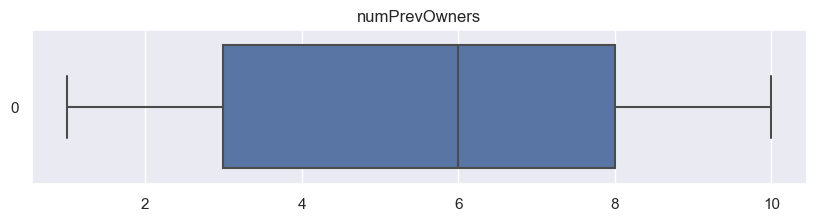

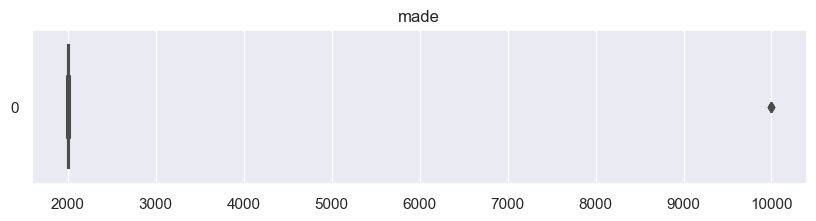

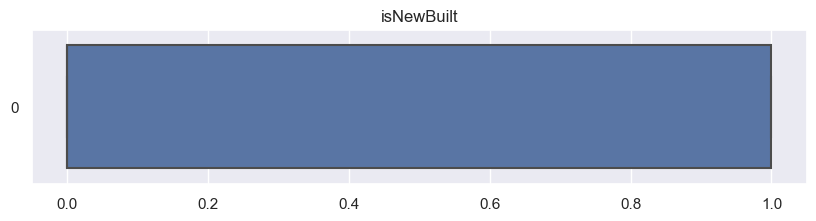

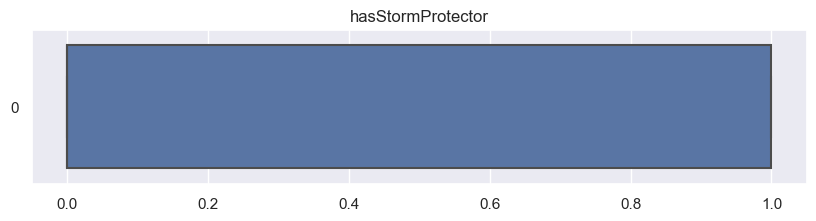

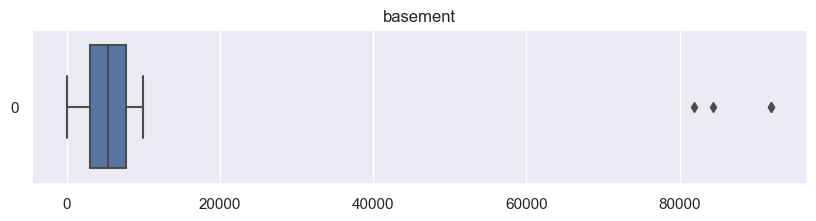

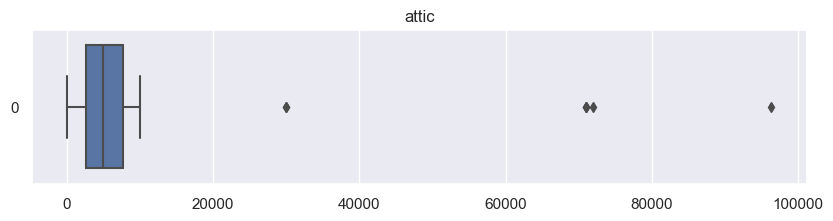

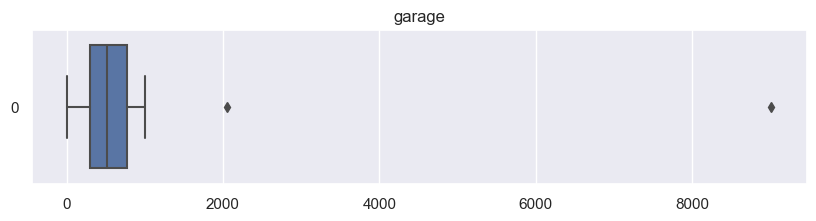

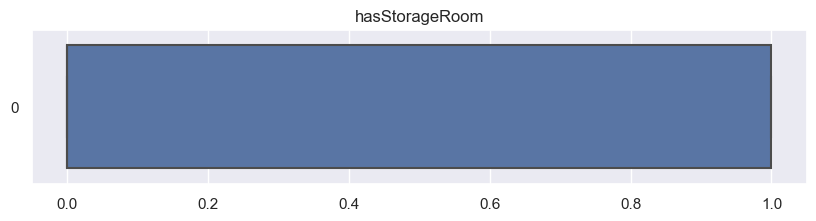

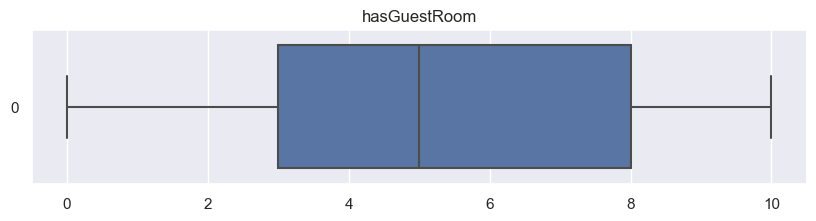

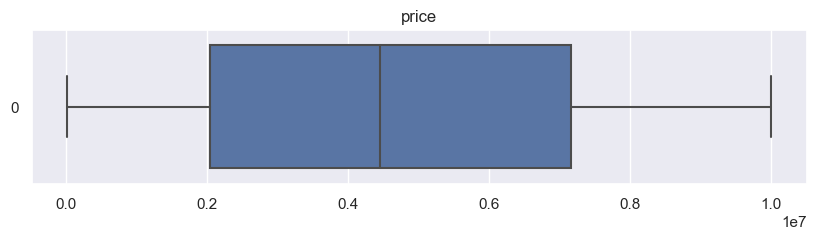

In [10]:
for col in train_data.columns:
    plt.figure(figsize=(10,2))
    sns.boxplot(data=train_data[col],orient='horizontal')
    plt.title(f'{col}')
    plt.show()


*Oultiers found in columns that can be entry error and can affect our predictions and model fitting. Removing them in the next step*

In [11]:
def remove_outliers_iqr(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_removed = [x for x in column if x >= lower_bound and x <= upper_bound]
    return outliers_removed

In [12]:
def remove_outliers_from_df(df):
    df_cleaned = df.copy()  # Create a copy to avoid modifying original DataFrame
    
    for col in df_cleaned.columns:
        cleaned_col = remove_outliers_iqr(df_cleaned[col])
        
        # Ensure the length matches the original DataFrame's length
        if len(cleaned_col) < len(df_cleaned):
            cleaned_col = np.append(cleaned_col, [np.nan] * (len(df_cleaned) - len(cleaned_col)))
        
        # Assign the cleaned column back to the DataFrame
        df_cleaned[col] = cleaned_col
    
    return df_cleaned

In [13]:
train_data_cleaned = remove_outliers_from_df(train_data)

*After Cleanup *

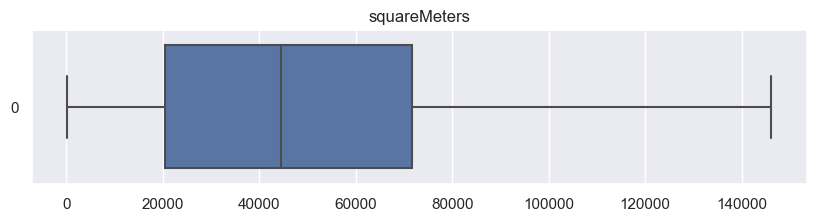

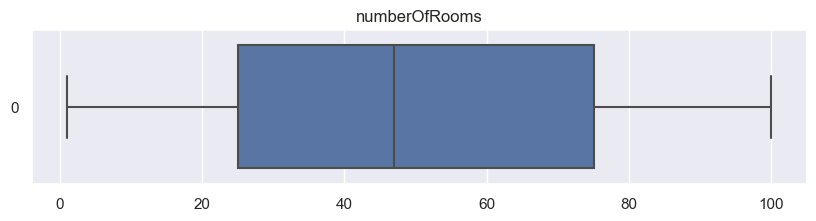

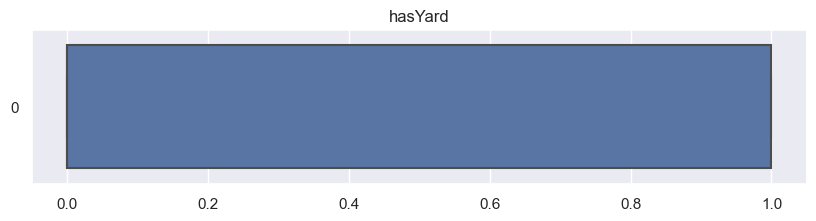

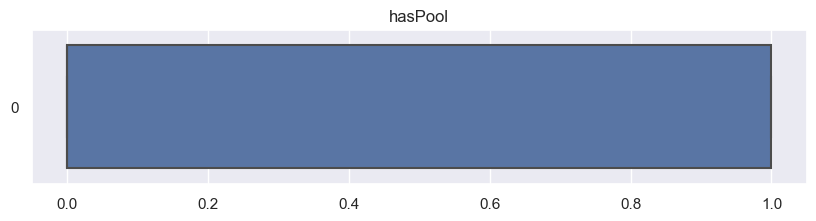

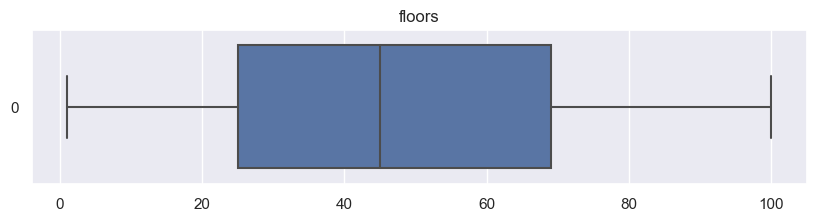

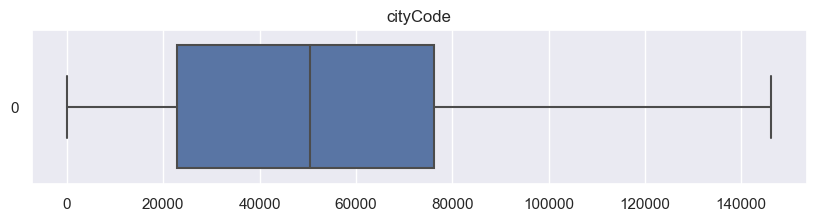

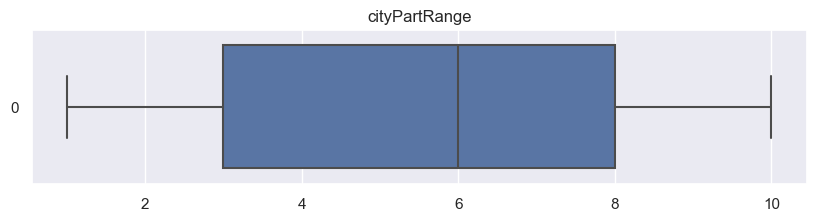

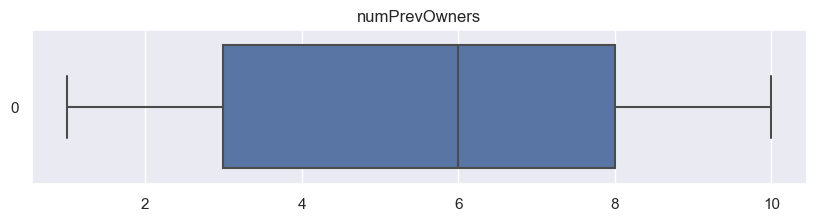

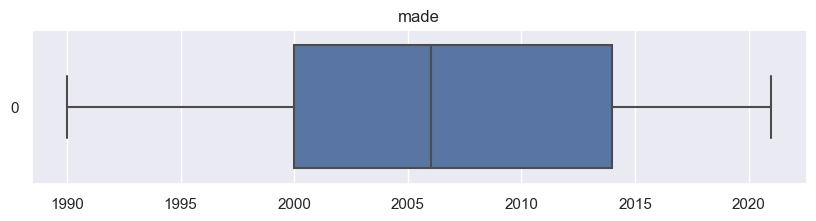

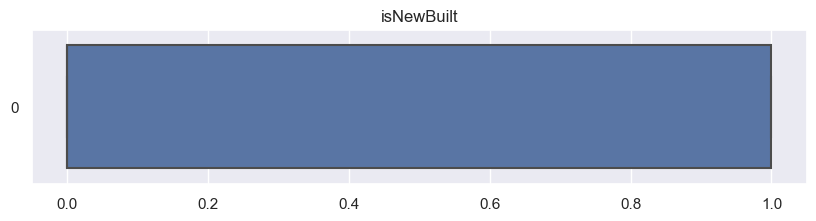

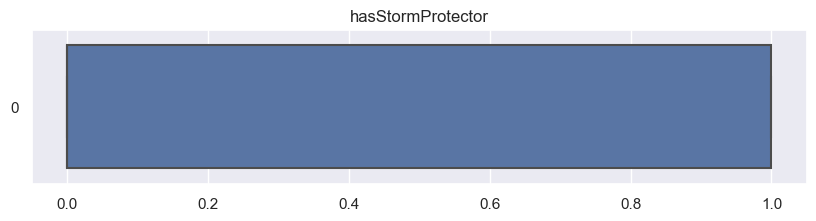

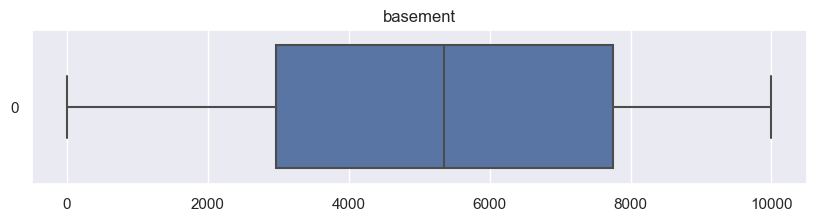

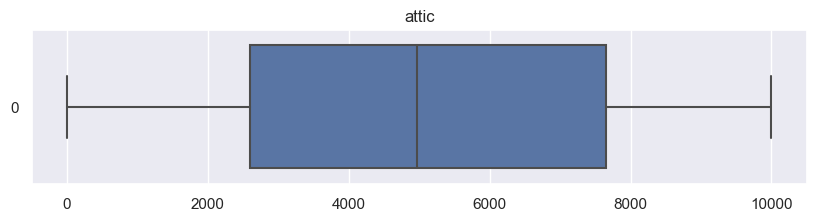

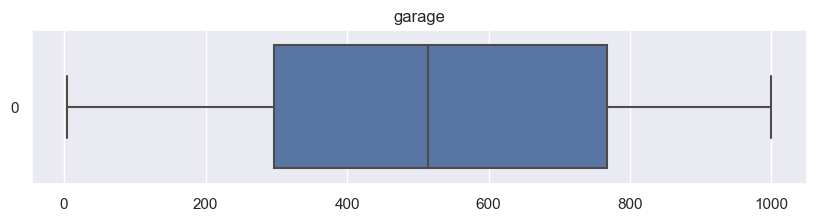

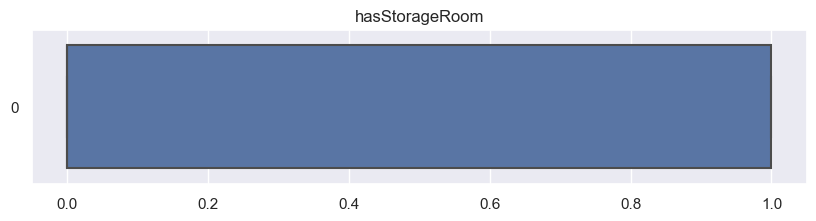

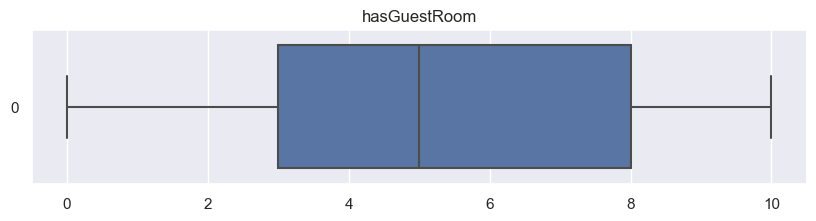

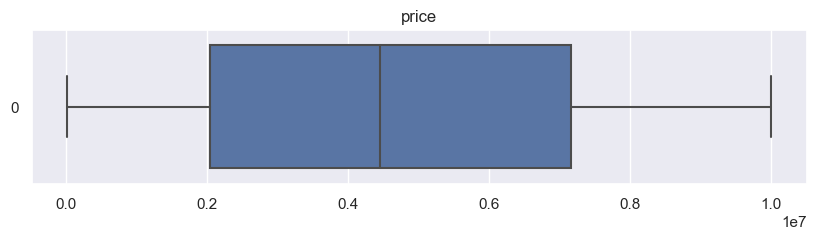

In [14]:
for col in train_data_cleaned.columns:
    plt.figure(figsize=(10,2))
    sns.boxplot(data=train_data_cleaned[col],orient='horizontal')
    plt.title(f'{col}')
    plt.show()

In [15]:
train_data.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,2.273000e+04,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,2.273000e+04
mean,4.658622e+04,48.241091,0.475891,0.452750,47.305983,50013.795996,5.585042,5.620766,2008.005059,0.467972,0.460009,5283.646634,5067.981698,530.469644,0.461681,5.153058,4.634457e+06
std,4.952124e+04,28.226428,0.499429,0.497773,47.777207,30006.637729,2.739533,2.713026,118.826777,0.498984,0.498409,3047.084412,3097.347939,274.840604,0.498540,3.055246,2.925163e+06
min,8.900000e+01,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04
25%,2.039275e+04,25.000000,0.000000,0.000000,25.000000,22936.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2977.250000,2599.000000,297.000000,0.000000,3.000000,2.041739e+06
50%,4.448400e+04,47.000000,0.000000,0.000000,45.000000,50414.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,4977.000000,515.000000,0.000000,5.000000,4.450823e+06
75%,7.154700e+04,75.000000,1.000000,1.000000,69.000000,76291.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7746.000000,7652.000000,767.000000,1.000000,8.000000,7.159920e+06
max,6.071330e+06,100.000000,1.000000,1.000000,6000.000000,491100.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000428e+07


## Grid Search for Hyper tuning

In [16]:
model =xgb.XGBRegressor(eval_metric='rmsle')

from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

In [17]:
X,y = train_data.drop(columns='price',axis=1),train_data['price']

grid_search = GridSearchCV(model,cv=5,scoring='neg_mean_absolute_error',verbose=1,param_grid=param_grid)

grid_search.fit(X,y)

grid_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 700}

Training xgboost with best parameters

In [21]:
model =xgb.XGBRegressor(eval_metric='rmsle',
                        learning_rate= 0.015, 
                        max_depth= 4, 
                        n_estimators= 700
                        )

#tfitting the data
model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
predictions = model.predict(test_data)

In [23]:
output = pd.DataFrame({"Id":test_data.index, "SalePrice":predictions})
output.to_csv('submission_S.csv', index=False)